In [156]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nemesispy.common.info_mol_id import mol_id
from nemesispy.common.constants import *
import os
from nemesispy.radtran.forward_model import ForwardModel
from nemesispy.radtran.calc_mmw import calc_mmw
import pyfastchem
from nemesispy.common.constants import ATM, G, AU, R_SUN, R_EAR_E, M_EAR, K_B, N_A, AMU
from nemesispy.common.info_mol_id import mol_id
from nemesispy.models.gas_profiles import gen_vmr
from nemesispy.models.TP_profiles import TP_madhu
from nemesispy.common.calc_hydrostat import calc_hydrostat
from spectres import spectres
import sys
import seaborn as sns

K_B_cgs = K_B * 1e7
print(K_B_cgs)

1.380649e-16


In [125]:
__projdir__ = os.environ['projdir']
fastchem_path = os.path.join(__projdir__, "runs/fastchem_try/FastChem")
f1_path = os.path.join(fastchem_path, "input/element_abundances/asplund_2020.dat")
f2_path = os.path.join(fastchem_path, "input/logK/logK.dat")
fastchem = pyfastchem.FastChem(f1_path, f2_path,1)
solar_abundances = np.array(fastchem.getElementAbundances())


FastChem initialisation summary:
  number of species: 523    elements: 28    molecules: 495    condensates: 0



['H2O', 'CO2', 'CO', 'NH3', 'CH4', 'TiO', 'VO', 'SH', 'SiO', 'H2', 'He', 'H']


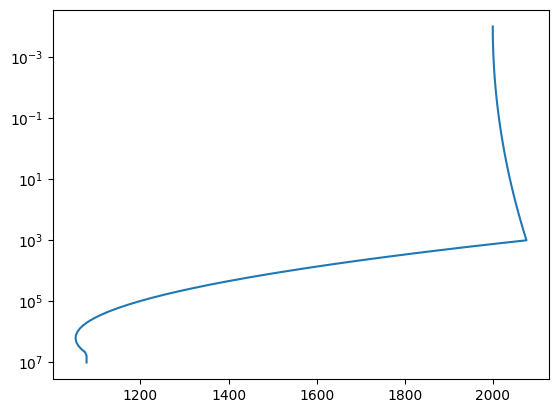

In [143]:
# Change this to own directory path
this_dir = os.path.join(__projdir__, "runs/nemesispy_scatter/nemesispy_agni")

data_path = os.path.join(this_dir, "example_data/LTT9779b_data.csv")
star_path = os.path.join(this_dir, "example_data/LTT9779_phoenix.csv")

df = pd.read_csv(data_path)
wv = df['wave'].values
wv_err = df['wave_err'].values
spec = df['dppm'].values
spec_err = df['dppm_err'].values
flux_star = pd.read_csv(star_path)['flux'].values


# LTT 9779b parameters (Jenkins 2020)
R_star = 0.949 * R_SUN
SMA = 0.01679 * AU
T_star = 5443.0
T_int = 200.0 # check?
M_plt = 29.32 * M_EAR
R_plt = 4.72 * R_EAR_E
g_plt = G * M_plt / R_plt**2

n_plevels = 100
NLAYER = n_plevels
P = np.logspace(2, -9, n_plevels) * ATM
P_model = P

ktable_list = 'LTT9779b_jake_R100' # wavelength bin to required dataset
# ktable_list = 'ltt9779b_5pt' # wavelength bin to required dataset
gas_names_active = ['H2O', 'CO2', 'CO', 'NH3', 'CH4', 'TiO', 'VO', 'SH', 'SiO']
gas_names_inactive = ['H2', 'He', 'H']

plot_species = ['H2O1', 'C1O2', 'C1O1', 'H3N1', 'C1H4', 'O1Ti1', 'O1V1', 'H1S1', 'O1Si1', 'H2', 'He', 'H']
plot_species_labels = gas_names_active + gas_names_inactive
plot_species_indices = []
plot_species_symbols = []

for i, species in enumerate(plot_species):
  index = fastchem.getGasSpeciesIndex(species)
  if index != pyfastchem.FASTCHEM_UNKNOWN_SPECIES:
    plot_species_indices.append(index)
    plot_species_symbols.append(plot_species_labels[i])
  else:
    print("Species", species, "to plot not found in FastChem")

print(plot_species_symbols)

gas_id = [mol_id[gas] for gas in gas_names_active] + [mol_id[gas] for gas in gas_names_inactive]
nvmr = len(gas_names_active)

# Setup
gas_id = np.array(gas_id)
iso_id = np.zeros_like(gas_id)
# __location__ = os.environ['nemesispy_dir']
__location__ = this_dir
ktable_path = os.path.join(__location__, "nemesispy/data/ktables")
lowres_file_paths = [f'{gas}_{ktable_list}.kta' for gas in gas_names_active]
for ipath,path in enumerate(lowres_file_paths):
    lowres_file_paths[ipath] = os.path.join(ktable_path,path)
cia_folder_path = os.path.join(__location__ , "nemesispy/data/cia")
cia_file_path = os.path.join(cia_folder_path,'exocia_hitran12_200-3800K.tab')

FM = ForwardModel()
FM.set_opacity_data(kta_file_paths=lowres_file_paths, cia_file_path=cia_file_path)
FM.set_planet_model(
    M_plt=M_plt,R_plt=R_plt,
    gas_id_list=gas_id,iso_id_list=iso_id,
    NLAYER=NLAYER
    )
wave_grid = FM.wave_grid

# Example TP Profile: Change as required
T = TP_madhu(P, -2.0, 1.2, 1.7, 2000.0, 0.8, 0.1)
plt.plot(T, P)
plt.gca().invert_yaxis()
plt.gca().set_yscale('log')
plt.show()

# Forward model analysis

We want to vary metallicity, a cloud parameterisation, and what the cloud is comprised of. 

In [150]:
def met_CO_to_VMR(metallicity, CO_ratio, T):
    # Link this to a chemical model, or something else
    # metallicity = 10.0 ** metallicity
    vmr = np.zeros((NLAYER, len(plot_species_symbols)))

    element_abundances = np.copy(solar_abundances)
    # h_abun = element_abundances[fastchem.getElementIndex('H')]
    for j in range(0, fastchem.getElementNumber()):
        if fastchem.getElementSymbol(j) != 'H' and fastchem.getElementSymbol(j) != 'He':
            element_abundances[j] = metallicity * element_abundances[j]

    element_abundances[fastchem.getElementIndex('C')] = CO_ratio * element_abundances[fastchem.getElementIndex('O')]
    fastchem.setElementAbundances(element_abundances)
    input_data = pyfastchem.FastChemInput()
    output_data = pyfastchem.FastChemOutput()
    input_data.pressure = P / 1e5 # Pa -> bar Noooo divide by 1e5 not multiply!!!!!
    input_data.temperature = T
    fastchem_flag = fastchem.calcDensities(input_data, output_data)
    print("fastchem_flag:", pyfastchem.FASTCHEM_MSG[fastchem_flag])
    gas_number_density = P * 10.0 / (K_B_cgs * T) # Pa->barye(cgs)
    number_densities = np.array(output_data.number_densities)

    for i in range(0, len(plot_species_symbols)):
        vmr[:, i] = number_densities[:, plot_species_indices[i]]/gas_number_density

    for k in range(NLAYER):
        if np.sum(vmr[k, :]) < 0.9:
            print(f"Sum of VMR for layer {k+1} = {np.sum(vmr[k, :])} < 0.9")
            # return np.nan # if gases not included exceed 20%
        vmr[k, :] = vmr[k, :] / np.sum(vmr[k, :])
    return vmr

Next up is the cloud parameterisation. We'll do something like model 9 in NEMESIS. This is very rough and was written quickly, so you might want to check it/write your own. In particular, the opacity will probably be quite off. But I'm assuming you want to use an optically thick cloud in which case you can just set it high.

In [151]:
from scipy.integrate import simpson

def cloud_top_pressure_to_A(VMR_model, H_model, T_model,
                            cloud_top_pressure, 
                            opacity = 10.0,
                            fsh = 1.0):
    
    A_model = np.zeros_like(P_model)
    
    cloud_top_height = np.interp(np.log(cloud_top_pressure),np.log(P_model[::-1]),H_model[::-1])
    
    
    
    grav = G*M_plt/((R_plt+H_model)**2)
    molwt = calc_mmw(gas_id, VMR_model.T)    
    
    scale = K_B* T_model / (molwt * grav)

    for i in np.where(H_model > cloud_top_height)[0]:
        if A_model[i-1] == 0:
            A_model[i] = 1
            continue

        A_model[i] = A_model[i-1] * np.exp(-(H_model[i] - H_model[i-1])/(scale[i]*fsh))
    A_model = A_model*(opacity/simpson(A_model,x=H_model))*1e4
        
    #A_model has to be shape (NLAYER,NMODES)
    A_model = A_model[:,None]
    return A_model

Now let's write a function that takes a path to a text file containing the real and imaginary refractive index spectrum for some aerosol.

In [152]:
def aerosol_path_to_forward_model(path, forward_model,
                                 mean_size = 0.05,
                                 size_variance = 0.05):
    
    aerosol = pd.read_csv(path, skiprows=2, header=None, sep='\s+')
    
    wave = aerosol[0].values
    n_real = aerosol[1].values
    n_imag = aerosol[2].values
    
    # Setting up phase function
    
    forward_model.clear_phase_function()
    
    n_imag_wave_grid = wave

    n_imag =  n_imag
    n_real = n_real

    forward_model.add_phase_function(mean_size = mean_size, 
                          size_variance = size_variance, 
                          n_imag = n_imag, 
                          n_imag_wave_grid = n_imag_wave_grid, 
                          n_real_reference = n_real,
                          n_real_reference_wave= wave_grid.min(),
                          iscat = 1)
    return forward_model

Let's test this and see what it looks like.

In [153]:
aerosol_path = os.path.join(this_dir, "example_data/enstatite.dat")
# FM = aerosol_path_to_forward_model(aerosol_path, FM)

# fig, axs = plt.subplots(2, 3, figsize=(12, 8))
# parameters = ['Extinction cross section','Scattering cross section',
#               'HG-fit: f','HG-fit: g1','HG-fit: g2','HG fit error']
# for i in range(6):
#     row = i // 3
#     col = i % 3
#     axs[row, col].plot(FM.wave_grid, FM.phase_func[:, :, i].transpose())
#     axs[row, col].legend([f'{parameters[i]} (mode 1)', f'{parameters[i]} (mode 2)'])

# plt.tight_layout()
# plt.show()

One iteration just to check the spectrum

In [154]:
phase_angle = 0
co_ratio = 0.5
metallicity = 1.0
cloud_top_pressure = 10.0 ** -1.0 * ATM
FM = aerosol_path_to_forward_model(aerosol_path,FM)

adjusted_VMR_model = met_CO_to_VMR(metallicity, co_ratio, T)
mmw = np.zeros(NLAYER)
for ipro in range(NLAYER):
    mmw[ipro] = calc_mmw(gas_id, adjusted_VMR_model[ipro,:])

H_model = calc_hydrostat(P=P, T=T, mmw=mmw,
        M_plt=M_plt, R_plt=R_plt)


A_model = cloud_top_pressure_to_A(adjusted_VMR_model, H_model, T, cloud_top_pressure)

spec_out = FM.calc_point_spectrum_hydro(P_model = P_model,
                                T_model = T,
                                VMR_model = adjusted_VMR_model,
                                solspec = flux_star,
                                A_model = A_model
                            )

fastchem_flag: convergence ok


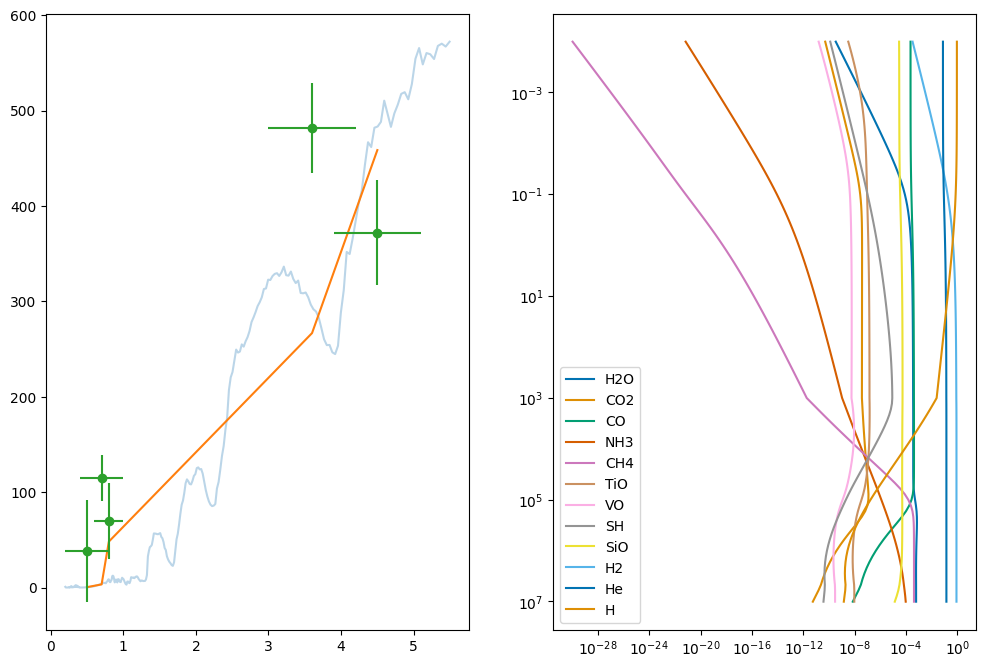

In [159]:
fig, ax = plt.subplots(1,2, figsize=(12, 8))
ax[0].plot(wave_grid, spec_out*1e6, alpha=0.3)
spec_binned = spectres(wv, wave_grid, spec_out*1e6)
ax[0].plot(wv, spec_binned)
ax[0].errorbar(wv, spec, yerr=spec_err, xerr=wv_err, fmt='o')
colors = sns.color_palette('colorblind', len(plot_species_symbols))
for i in range(len(plot_species_symbols)):
    ax[1].plot(adjusted_VMR_model[:,i], P_model, label=plot_species_symbols[i], color=colors[i])
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].invert_yaxis()
plt.legend()
plt.show()
    

Now we can run our forward model analysis. You might want to parallelise over one of the loops if it's taking too long. It will take a minute or so to start running for the first time.

In [ ]:
phase_angle = 0
co_ratio = 0.5
n_steps = 10
metallicities = 10**np.linspace(0,3,n_steps)
cloud_top_pressures = 10**np.linspace(2,-3,n_steps) * ATM
aerosol_paths = [aerosol_path]

print(f"Min, Max metallicity: {metallicities.min(),metallicities.max()}")
print(f"Min, Max cloud top pressures (bar): {cloud_top_pressures.min()/ATM,cloud_top_pressures.max()/ATM}")
      

chisq_grid = np.zeros(((len(aerosol_paths),len(metallicities),len(cloud_top_pressures))))

for iap, ap in enumerate(aerosol_paths):
    
    FM = aerosol_path_to_forward_model(ap,FM)
    
    for im, m in enumerate(metallicities):
        
        adjusted_VMR_model = met_CO_to_VMR(m, co_ratio, T)
        mmw = np.zeros(NLAYER)
        for ipro in range(NLAYER):
            mmw[ipro] = calc_mmw(gas_id, adjusted_VMR_model[ipro,:])
        
        H_model = calc_hydrostat(P=P, T=T, mmw=mmw,
                M_plt=M_plt, R_plt=R_plt)
        
        # print(H_model)
        
        for ictp, ctp in enumerate(cloud_top_pressures):

            A_model = cloud_top_pressure_to_A(adjusted_VMR_model, H_model, T, ctp)

            spec_out = FM.calc_point_spectrum_hydro(P_model = P_model,
                                          T_model = T,
                                          VMR_model = adjusted_VMR_model,
                                          solspec = flux_star,
                                          A_model = A_model
                                  )
            spec_binned = spectres(wv, wave_grid, spec_out*1e6)
            chisq = ((spec_binned - spec)**2/spec_err**2).mean()
            chisq_grid[iap,im,ictp] = chisq      
            
            output = f"Chisq: {chisq:.2f}, Metallicity: {m:.2e}, Cloud top pressure (bar): {ctp/101325:.2e}, Path: {ap}, Spectrum: {ictp+im*n_steps+iap*n_steps*n_steps+1}/{chisq_grid.size}"
            sys.stdout.write(f"\r{output.ljust(800)}") 
            sys.stdout.flush()


Min, Max metallicity: (1.0, 1000.0)
Min, Max cloud top pressures (bar): (0.001, 100.0)
fastchem_flag: convergence ok
Chisq: 9.18, Metallicity: 1.00e+00, Cloud top pressure (bar): 1.00e-03, Path: /STEM/data/project/users/ab39556/runs/nemesispy_scatter/nemesispy_agni/example_data/enstatite.dat, Spectrum: 10/100                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               fastchem_flag: convergence ok
Chisq: 8.53, Metallicity: 2.15e+00, Cloud top pressur

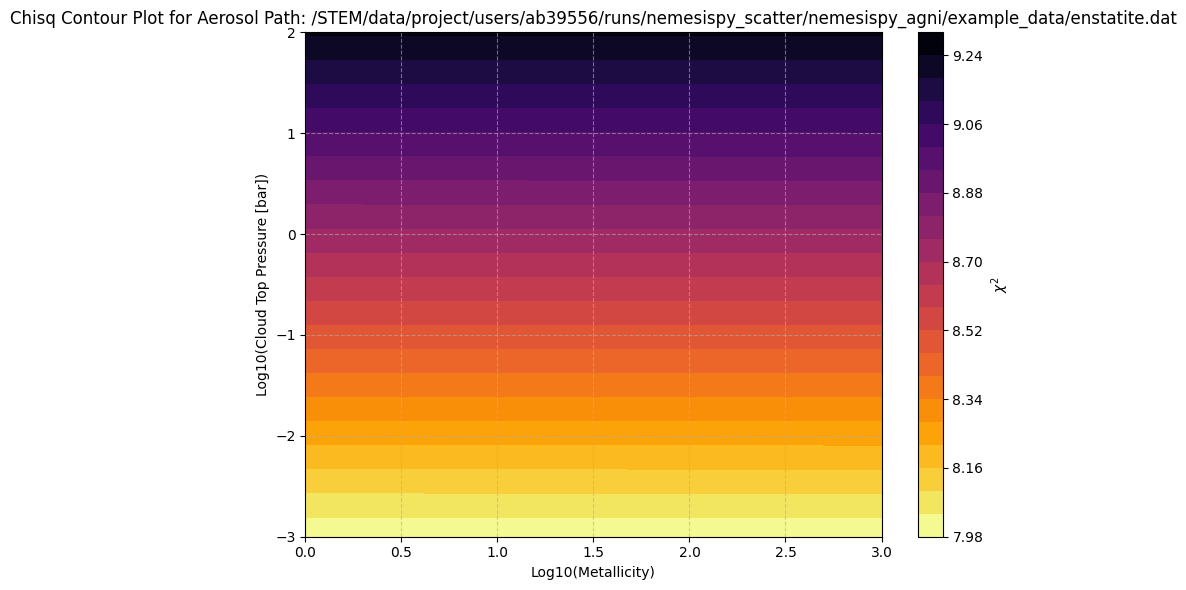

In [ ]:
for iap, ap in enumerate(aerosol_paths):
    X, Y = np.meshgrid(np.log10(metallicities), np.log10(cloud_top_pressures / 101325)) 
    Z = chisq_grid[iap]

    plt.figure(figsize=(8, 6))
    contour = plt.contourf(X, Y, Z, levels=20, cmap='inferno_r')
    plt.colorbar(contour, label=r'$\chi^2$')

    plt.title(f'Chisq Contour Plot for Aerosol Path: {ap}')
    plt.xlabel('Log10(Metallicity)')
    plt.ylabel('Log10(Cloud Top Pressure [bar])')
    plt.grid(True, which='both', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()